In [1]:
import zipfile
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter

pd.set_option('copy_on_write', True)
sns.set_style("darkgrid")

root = Path("/mnt/trove/wdd/wdd_output_2024/cam0/")

In [2]:
Counter(path.suffix for path in sorted(root.rglob("*")))

Counter({'.zip': 26})

In [3]:
zipfiles = []
for path in sorted(root.rglob("*")):
    if path.suffix == ".zip":
        zipfiles.append(path)

In [4]:
dfs = []
for path in zipfiles:
    waggle_data = []
    with zipfile.ZipFile(path, "r") as archive:
        for info in archive.infolist():
            filepath = info.filename
            if filepath.endswith("waggle.json"):
                with archive.open(filepath) as file:
                    json_data = json.load(file)
                    waggle_data.append(json_data)

    df = pd.DataFrame(waggle_data)
    dfs.append(df)

In [5]:
# source: https://stackoverflow.com/a/71887460
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386
    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )


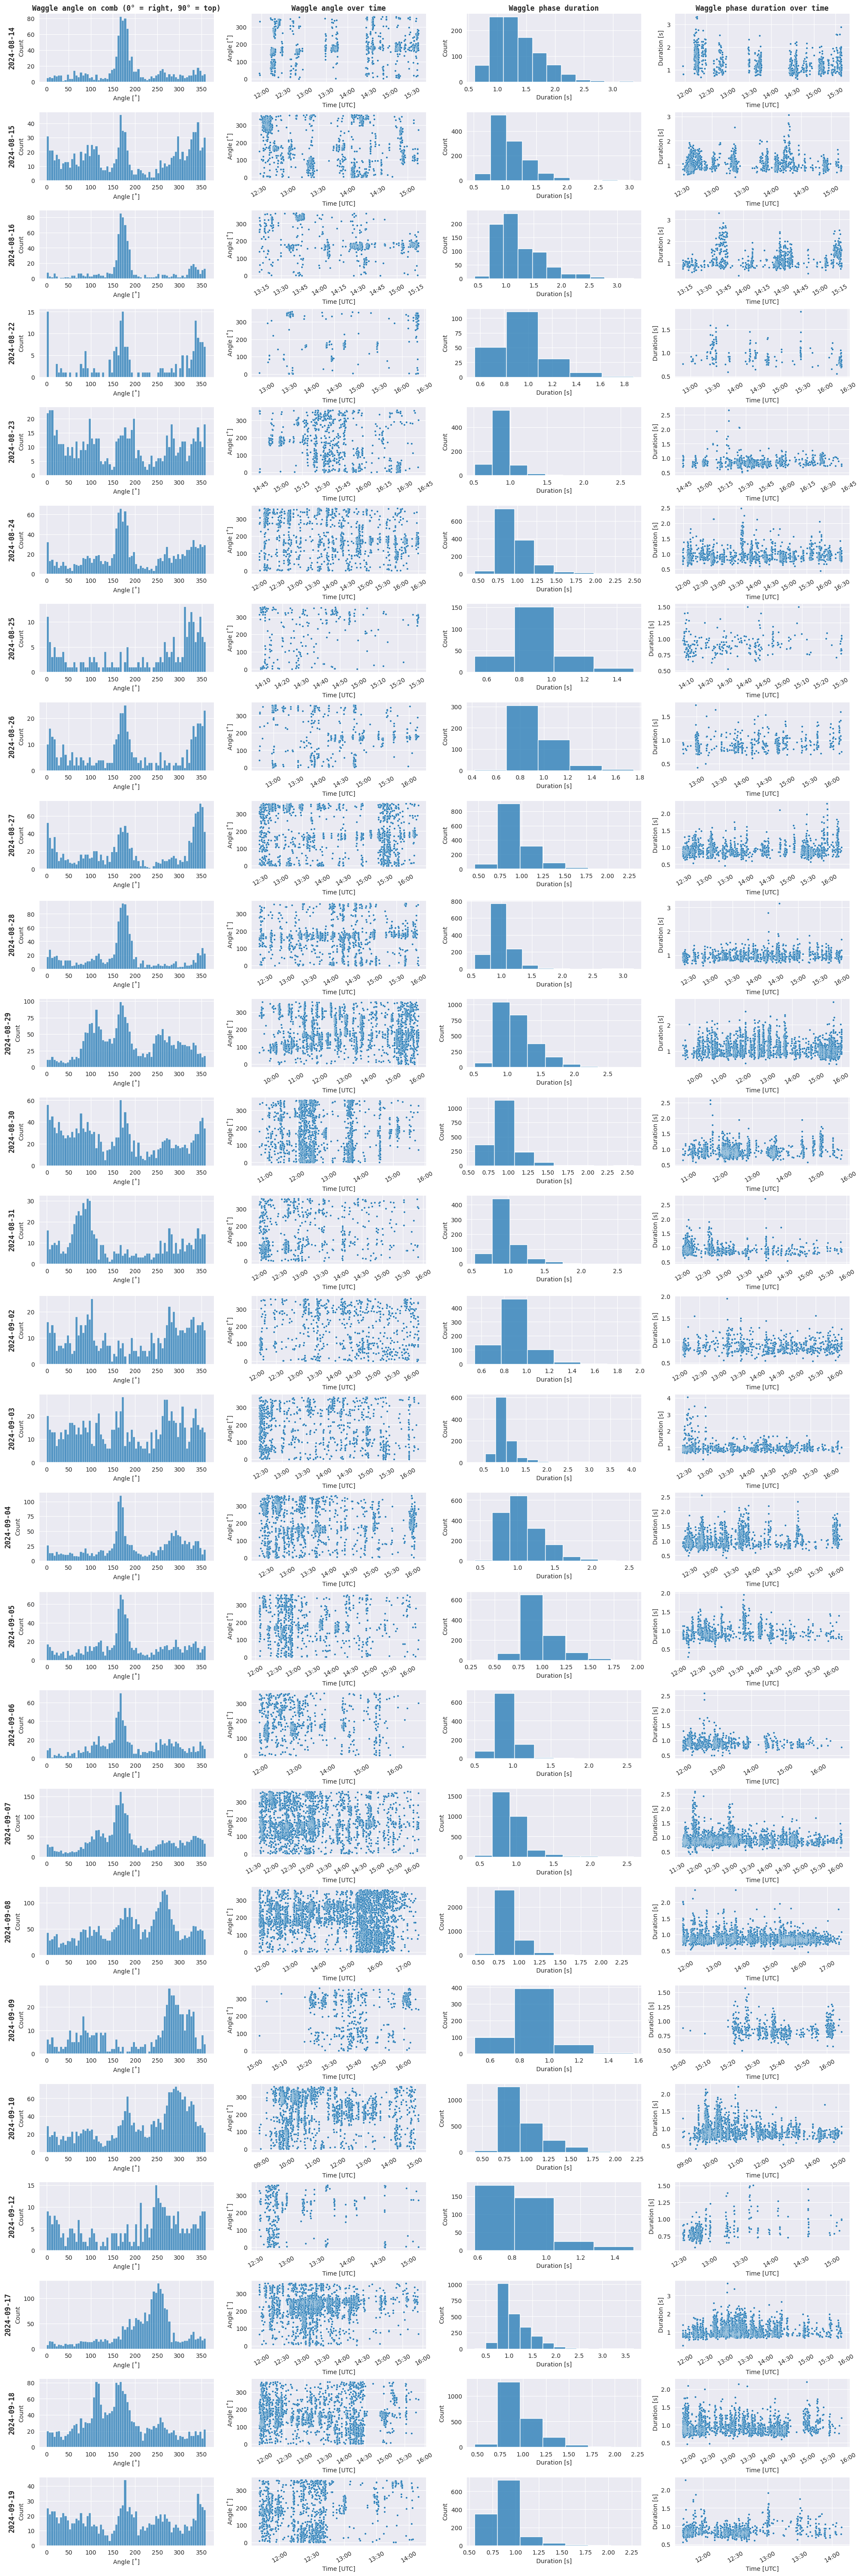

In [6]:
fig, ax = plt.subplots(26, 4, figsize=(20, 60), constrained_layout=True)

row_headers = list(map(lambda df: df["timestamp_begin"].values[0][:10], dfs))
col_headers = [
    "Waggle angle on comb (0° = right, 90° = top)", 
    "Waggle angle over time",
    "Waggle phase duration", 
    "Waggle phase duration over time"
]

for idx, df in enumerate(dfs):
    waggles_df = df.loc[df["predicted_class_label"] == "waggle"]
    waggles_df["waggle_angle_deg"] = (waggles_df.waggle_angle.values * 180 / np.pi) % 360
    sns.histplot(waggles_df.waggle_angle_deg.values, binwidth=5, ax=ax[idx, 0])
    ax[idx, 0].set_xlabel("Angle [˚]")

    waggles_df["timestamp_begin"] = pd.to_datetime(waggles_df["timestamp_begin"], utc=True)
    waggles_df_sorted = waggles_df.sort_values(by="timestamp_begin")

    sns.scatterplot(data=waggles_df_sorted, x="timestamp_begin", y="waggle_angle_deg", s=10, ax=ax[idx, 1])
    ax[idx, 1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
    ax[idx, 1].tick_params(axis="x", labelrotation=30)
    ax[idx, 1].set_xlabel("Time [UTC]")
    ax[idx, 1].set_ylabel("Angle [˚]")
    
    sns.histplot(waggles_df.waggle_duration.values, binwidth=0.25, ax=ax[idx, 2])
    ax[idx, 2].set_xlabel("Duration [s]")

    sns.scatterplot(data=waggles_df_sorted, x="timestamp_begin", y="waggle_duration", s=10, ax=ax[idx, 3])
    ax[idx, 3].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
    ax[idx, 3].tick_params(axis="x", labelrotation=30)
    ax[idx, 3].set_xlabel("Time [UTC]")
    ax[idx, 3].set_ylabel("Duration [s]")
    
font_kwargs = dict(fontfamily="monospace", fontweight="bold", fontsize="large")
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)
plt.show()